# EURO STOXX50 - Base GBM Model

In this notebook, we detail our implementation of our base Geometric Brownian Motion model for the [Outperformance Bonus Certificate EURO STOXX 50](https://derivative.credit-suisse.com/ch/ch/en/detail/outperformance-bonus-certificate-euro-stoxx-50/CH1149494077/114949407), a derivative of the SX5E stock.

For our risk-neutral valuation, we perform the following:
1) Look back M time steps for historical data (given an M of 252, we'll take the subset of data from 11 August 2022 to 9 August 2023)
2) Estimate our model parameters ($\sigma = \sqrt{sample\ variance}$) from historical data for the GBM model)
3) Plug our estimated model parameters into our simulation functions and simulate N simulations from 10 August 2023 to our maturity date (e.g. monte carlo, monte carlo with antithetic variates)
4) Calculate our predicted stock price using the mean of the N simulations on our maturity date
5) Calculate our option price by pulling back from the predicted stock price

## Importing Data

In [1]:
# External Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from numba import jit
import time
import datetime
import warnings

warnings.filterwarnings("ignore") # Suppress warnings from numba

# Our Code
from payoff_function import PayoffFunctions

We import our historical stock data, taken from [Yahoo Finance's STOXX50E](https://finance.yahoo.com/quote/%5ESTOXX50E/) into a Pandas dataframe called `S_all`:

In [2]:
S_all = pd.read_csv("STOXX50E_2Aug2022_13Nov2023.csv")
S_all = S_all[['Date', 'Adj Close']]

We then import the Euro area yields with 1-year maturity period, taken from the [European Central Bank data portal](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html), as data for our risk-free interest rate:

In [3]:
ir = pd.read_csv("euro_area_1_year_yield_curve.csv").rename(columns={"DATE": "Date", "TIME PERIOD": "Date String", "Yield curve spot rate, 1-year maturity - Government bond, nominal, all issuers whose rating is triple A - Euro area (changing composition) (YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_1Y)": "Interest Rate"})
ir

,Date,Date String,Interest Rate
0,2004-09-06,06 Sep 2004,2.298838
1,2004-09-07,07 Sep 2004,2.328891
2,2004-09-08,08 Sep 2004,2.346666
3,2004-09-09,09 Sep 2004,2.308988
4,2004-09-10,10 Sep 2004,2.271566
...,...,...,...
4903,2023-11-07,07 Nov 2023,3.443486
4904,2023-11-08,08 Nov 2023,3.429405
4905,2023-11-09,09 Nov 2023,3.442951
4906,2023-11-10,10 Nov 2023,3.494435


Our timestep (dt) is defined as $\frac{1}{252}$, indicating 1 day out of 252 working days in a year.

In [4]:
dt = 1/252

We define our dates of interest as the dates between 9 Aug 2023 and 9 Nov 2023 (62 days in total):

In [5]:
actual_dates = ir[(ir['Date'] >= '2023-08-09') & (ir['Date'] <= '2023-11-09')]['Date'].values
simulation_dates = ir[(ir['Date'] >= '2023-08-08') & (ir['Date'] <= '2023-11-08')]['Date'].values

## Obtaining Model Parameters from Historical Data
For our base GBM model, we are only interested in $\sigma$, the sample variance of our historical data for each day.

For each day in the sliding window (62 days in total), we look back M days and calculate $\sigma$, starting from 9 August 2023. This gives us a total of 252 trading days from 11 August 2022 to 9 August 2023.

In [6]:
M = 252
sigma = np.zeros(len(actual_dates), dtype=np.float32)
for i, date in enumerate(simulation_dates):
    date_index = S_all.loc[S_all['Date'] == date].index[0] + 1
    history_data = list(S_all.iloc[date_index-M:date_index, ]['Adj Close'])
    log_history_data = np.log(history_data)
    log_return = log_history_data[1:] - log_history_data[:-1]
    sigma[i] = np.std(log_return) / np.sqrt(dt)

In [7]:
r = ir[ir['Date'].isin(simulation_dates)]['Interest Rate'].values / 100
v = r - sigma**2 / 2
St = S_all[S_all['Date'].isin(simulation_dates)]['Adj Close'].values
Nsim=1000
T = np.array(range(485, 485-len(actual_dates), -1)) / 252

## Simulating data


In [8]:
# TODO: Shift all simulation functions into a Python file
def simulate_gbm_exact(n_sim, S_0, v, sigma, delta_t, T):
    '''
    GBM simulation using Monte Carlo

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))

    for i in tqdm(range(n_sim)):
    # for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
    return S_t

@jit
def simulate_gbm_exact_jit(n_sim, S_0, v, sigma, delta_t, T):
    '''
    GBM simulation using Monte Carlo

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))

    # for i in tqdm(range(n_sim)):
    for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma*np.sqrt(delta_t)*Z[i][j-1])
    return S_t

In [9]:
sim_S = simulate_gbm_exact_jit(10, history_data[-1], v[0], sigma[0], dt, T[0])
print(f"No. of timesteps simulated: {len(sim_S[0])}")

No. of timesteps simulated: 486


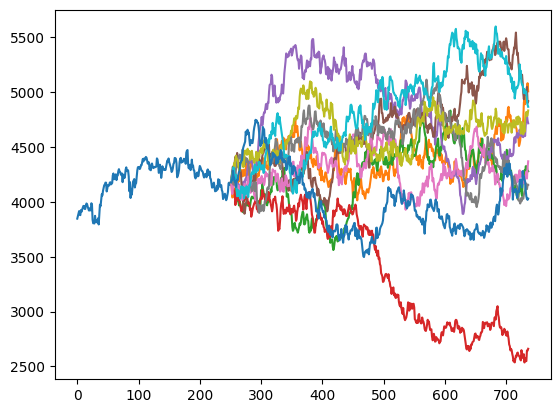

In [10]:
plot1 = pd.Series(history_data, index=np.arange(len(history_data)))
plt.plot(plot1)
for i in range(len(sim_S)):
    plot2 = pd.Series(sim_S[i], index=np.arange(len(history_data)-1, len(history_data)-1+len(sim_S[0])))
    plt.plot(plot2)
plt.show()

# Risk-Neutral Valuation

To calculate T between our initial window date (9 Aug 2023) and the final fixing date (14 July 2025), we use the [timeanddate website](https://www.timeanddate.com/date/workdays.html) and set the country to Germany (a country in the European Union). The number of working days in this range, excluding the end date is 485.

### Normal Monte Carlo Simulation

In [11]:
predicted_derivative_dict = dict()
predicted_derivative_dict['date'] = actual_dates

In [12]:
mc_means = []
mc_vars = []

mc_jit_start = time.perf_counter()
for i in tqdm(range(len(simulation_dates))):
    sim_S_jit = simulate_gbm_exact_jit(Nsim, St[i], v[i], sigma[i], dt, T[i])
    sim_S_df = pd.DataFrame(sim_S_jit)
    
    sim_Note = np.exp(-r[i]*T[i])*sim_S_df.apply(PayoffFunctions.payoff_original, axis=1)
    note_MC = np.mean(sim_Note)
    note_MC_var = np.var(sim_Note)/Nsim
    
    mc_means.append(note_MC)
    mc_vars.append(note_MC_var)
    
mc_jit_end = time.perf_counter()
print(f"Time taken (MC): {mc_jit_end - mc_jit_start}s\n")

lower_percentile = mc_means[0]-1.96*np.sqrt(mc_vars[0])
higher_percentile = mc_means[0]+1.96*np.sqrt(mc_vars[0])
print(f"Note Value (MC) on {actual_dates[0]}: {mc_means[0]}")
print(f"Estimate Variance: {mc_vars[0]}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")
predicted_derivative_dict['MC_Mean'] = mc_means
predicted_derivative_dict['MC_Var'] = mc_vars

100%|███████████████████████████████████████████| 66/66 [00:02<00:00, 24.47it/s]

Time taken (MC): 2.753051479001442s

Note Value (MC) on 2023-08-09: 1429.8882719443952
Estimate Variance: 191.24310605844263
95% Confidence Interval: [1402.7832997762835, 1456.993244112507]


### Antithetic Variate Simulation

In [13]:
def simulate_gbm_exact_av(n_sim, S_0, v, sigma, delta_t, T, collate=False):
    '''
    GBM simulation using Monte Carlo with antithetic variates

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    - collate - Boolean: True - Returns [S_t[0], S_tilde_t[0], ..., S_t[n_sim-1], S_tilde_t[n_sim-1]],
                         False - Returns [S_t[0], ..., S_t[n_sim-1], S_tilde_t[0], ..., S_tilde_t[n_sim-1]],
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim, n_periods+1), S_0)
    S_tilde_t = np.full((n_sim, n_periods+1), S_0)
    Z = np.random.normal(size=(n_sim, n_periods))
    
    for i in tqdm(range(n_sim)):
    # for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * Z[i][j-1])
            S_tilde_t[i][j] = S_tilde_t[i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * (-Z[i][j-1]))
            # S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma * np.sqrt(delta_t) * Z[i][j-1])
            # S_tilde_t[i][j] = S_tilde_t[i][j-1] * np.exp(v*delta_t - 0.5*(sigma**2)*delta_t + sigma * np.sqrt(delta_t) * (-Z[i][j-1]))

    if collate:
        collated = [None] * (2*n_sim)
        for i in range(n_sim):
            collated[2*i] = S_t[i]
            collated[2*i+1] = S_tilde_t[i]
        return collated
    S_t = np.append(S_t, S_tilde_t, 0)
    return S_t

@jit
def simulate_gbm_exact_av_jit(n_sim, S_0, v, sigma, delta_t, T):
    '''
    GBM simulation using Monte Carlo with antithetic variates

    Takes in the following parameters:
    - n_sim (integer): No. of simulations to generate
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - delta_t (float): Value of one timestep (e.g. 1 / 252, 1 day out of 252 working days in a year)
    - T (float): End date, used to calculate no. of periods
    - collate - Boolean: True - Returns [S_t[0], S_tilde_t[0], ..., S_t[n_sim-1], S_tilde_t[n_sim-1]],
                         False - Returns [S_t[0], ..., S_t[n_sim-1], S_tilde_t[0], ..., S_tilde_t[n_sim-1]],
    '''
    n_periods = int(T / delta_t)
    S_t = np.full((n_sim*2, n_periods+1), S_0) # Combined S_tilde_t with S_t
    Z = np.random.normal(size=(n_sim, n_periods))
    
    #for i in tqdm(range(n_sim)):
    for i in range(n_sim):
        for j in range(1, n_periods+1):
            S_t[i][j] = S_t[i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * Z[i][j-1])
            # S_tilde is stored in the second half of the array
            S_t[n_sim+i][j] = S_t[n_sim+i][j-1] * np.exp(v*delta_t + sigma * np.sqrt(delta_t) * (-Z[i][j-1]))

    return S_t

In [14]:
av_means = []
av_vars = []

av_jit_start = time.perf_counter()
for i in tqdm(range(len(simulation_dates))):
    sim_S_AV_jit = simulate_gbm_exact_av_jit(int(Nsim/2), St[i], v[i], sigma[i], dt, T[i])    
    sim_S_AV_df = pd.DataFrame(sim_S_AV_jit)
    
    sim_Note_AV = np.exp(-r[i]*T[i])*sim_S_AV_df.apply(PayoffFunctions.payoff_original, axis=1)
    note_AV = np.mean(sim_Note_AV)
    note_AV_var = np.var(sim_Note_AV)/Nsim
    av_means.append(note_AV)
    av_vars.append(note_AV_var)

av_jit_end = time.perf_counter()
print(f"Time taken (AV): {av_jit_end - av_jit_start}s\n")

lower_percentile = av_means[0]-1.96*np.sqrt(av_vars[0])
higher_percentile = av_means[0]+1.96*np.sqrt(av_vars[0])
print(f"Note Value (AV) on {actual_dates[0]}: {av_means[0]}")
print(f"Estimate Variance: {av_vars[0]}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")
predicted_derivative_dict['AV_Mean'] = av_means
predicted_derivative_dict['AV_Var'] = av_vars

100%|███████████████████████████████████████████| 66/66 [00:02<00:00, 22.48it/s]

Time taken (AV): 2.9371798140018655s

Note Value (AV) on 2023-08-09: 1390.9200622474686
Estimate Variance: 152.94734753510147
95% Confidence Interval: [1366.6803730932975, 1415.1597514016398]


### Control Variate Simulation

In [15]:
def simulate_gbm_exact_cv(n_sim, S_0, v, sigma, delta_t, T, r, payoff_fn, n1=1000):
    hsi_simulations_pre = simulate_gbm_exact(n1, S_0, v, sigma, delta_t, T)
    payoffs_pre = np.array([payoff_fn(sim) for sim in hsi_simulations_pre])
    sim_notes_pre = np.exp(-r * T) * payoffs_pre
    c = -np.cov(sim_notes_pre, hsi_simulations_pre[:,-1])[0,1] / (S_0**2 * np.exp(2*r*T) * (np.exp(sigma**2*T)-1))
    
    hsi_simulations_cv = simulate_gbm_exact(n_sim, S_0, v, sigma, delta_t, T)
    payoffs_cv = np.array([payoff_fn(sim) for sim in hsi_simulations_cv])
    sim_notes_cv = np.exp(-r * T) * payoffs_cv + c*(hsi_simulations_cv[:,-1] - S_0*np.exp(r*T))
    return sim_notes_cv

@jit
def simulate_gbm_exact_cv_jit(n_sim, S_0, v, sigma, delta_t, T, r, payoff_fn, n1=1000):
    hsi_simulations_pre = simulate_gbm_exact_jit(n1, S_0, v, sigma, delta_t, T)
    payoffs_pre = np.array([payoff_fn(sim) for sim in hsi_simulations_pre])
    sim_notes_pre = np.exp(-r * T) * payoffs_pre
    c = -np.cov(sim_notes_pre, hsi_simulations_pre[:,-1])[0,1] / (S_0**2 * np.exp(2*r*T) * (np.exp(sigma**2*T)-1))
    
    hsi_simulations_cv = simulate_gbm_exact_jit(n_sim, S_0, v, sigma, delta_t, T)
    payoffs_cv = np.array([payoff_fn(sim) for sim in hsi_simulations_cv])
    sim_notes_cv = np.exp(-r * T) * payoffs_cv + c*(hsi_simulations_cv[:,-1] - S_0*np.exp(r*T))
    return sim_notes_cv

In [16]:
cv_means = []
cv_vars = []

cv_jit_start = time.perf_counter()
for i in tqdm(range(len(simulation_dates))):
    sim_Note_CV_jit = simulate_gbm_exact_cv_jit(Nsim, St[i], v[i], sigma[i], dt, T[i], r[i], payoff_fn=PayoffFunctions.payoff_original)
    
    note_CV = np.mean(sim_Note_CV_jit)
    note_CV_var = np.var(sim_Note_CV_jit)/Nsim
    cv_means.append(note_CV)
    cv_vars.append(note_CV_var)
    
cv_jit_end = time.perf_counter()
print(f"Time taken (CV): {cv_jit_end - cv_jit_start}s\n")

lower_percentile = cv_means[0]-1.96*np.sqrt(cv_vars[0])
higher_percentile = cv_means[0]+1.96*np.sqrt(cv_vars[0])
print(f"Note Value (CV) on {actual_dates[0]}: {cv_means[0]}")
print(f"Estimate Variance: {cv_vars[0]}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")
predicted_derivative_dict['CV_Mean'] = cv_means
predicted_derivative_dict['CV_Var'] = cv_vars

100%|███████████████████████████████████████████| 66/66 [00:05<00:00, 12.27it/s]

Time taken (CV): 5.379843826998695s

Note Value (CV) on 2023-08-09: 1398.668187840209
Estimate Variance: 4.379306468633685
95% Confidence Interval: [1394.566536498383, 1402.769839182035]


### Stratified Sampling Simulation

In [17]:
def simulate_gbm_1_shoot_ss(n_strata, n_sim_s, S_0, v, sigma, T):
    '''
    GBM simulation using Monte Carlo with stratified sampling

    Takes in the following parameters:
    - n_strata (integer): No. of strata
    - n_sim_s (integer): No. of simulations to generate per strata (Total = n_strata * n_sim_s)
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - T (float): End date, used to calculate no. of periods
    '''
    V = np.random.uniform(size=n_sim_s) / n_strata
    for i in range(1, n_strata):
        V = np.append(V, (i + np.random.uniform(size=n_sim_s)) / n_strata, 0 )
    Z = np.array(scipy.stats.norm.ppf(V))
    S_T = S_0 * np.exp(v*T + sigma*np.sqrt(T)*Z)
    # S_T = S_0 * np.exp(v*T - 0.5*(sigma**2)*T + sigma*np.sqrt(T)*Z)
    return S_T.reshape(n_sim_s*n_strata, 1)

@jit
def simulate_gbm_1_shoot_ss_jit(n_strata, n_sim_s, S_0, v, sigma, T):
    '''
    GBM simulation using Monte Carlo with stratified sampling

    Takes in the following parameters:
    - n_strata (integer): No. of strata
    - n_sim_s (integer): No. of simulations to generate per strata (Total = n_strata * n_sim_s)
    - S_0 (float): Price of S at time 0
    - v (float): Given by (r - sigma^2 / 2), where r is the risk-free interest rate 
                 and sigma is the volatility calculated from historical data
    - sigma (float): Volatility calculated from historical data (sqrt of variance)
    - T (float): End date, used to calculate no. of periods
    '''
    V = np.empty(n_strata*n_sim_s, dtype=np.float64)
    for i in range(n_strata):
        V[i*n_sim_s:(i+1)*n_sim_s] = (i + np.random.uniform(size=n_sim_s)) / n_strata
        # V = np.append(V, (i + np.random.uniform(size=n_sim_s)) / n_strata, 0 )
    Z = np.array(scipy.stats.norm.ppf(V))
    S_T = S_0 * np.exp(v*T + sigma*np.sqrt(T)*Z)
    # S_T = S_0 * np.exp(v*T - 0.5*(sigma**2)*T + sigma*np.sqrt(T)*Z)
    return S_T.reshape(n_sim_s*n_strata, 1)

In [18]:
ss_means = []
ss_vars = []

n_strata = 5
n_sim_s = Nsim // n_strata

ss_jit_start = time.perf_counter()
for i in tqdm(range(len(simulation_dates))):
    sim_S_SS_jit = simulate_gbm_1_shoot_ss_jit(n_strata, n_sim_s, St[i], v[i], sigma[i], T[i])
    sim_S_SS_df = pd.DataFrame(sim_S_SS_jit)
    
    sim_Note_SS = np.exp(-r[i]*T[i])*sim_S_SS_df.apply(PayoffFunctions.payoff_original, axis=1)
    note_SS = np.mean(sim_Note_SS)
    note_SS_var = np.var(sim_Note_SS)/Nsim
    ss_means.append(note_SS)
    ss_vars.append(note_SS_var)
    
ss_jit_end = time.perf_counter()
print(f"Time taken (SS): {ss_jit_end - ss_jit_start}s\n")

lower_percentile = ss_means[0]-1.96*np.sqrt(ss_vars[0])
higher_percentile = ss_means[0]+1.96*np.sqrt(ss_vars[0])
print(f"Note Value (SS) on {actual_dates[0]}: {ss_means[0]}")
print(f"Estimate Variance: {ss_vars[0]}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")
predicted_derivative_dict['SS_Mean'] = ss_means
predicted_derivative_dict['SS_Var'] = ss_vars

100%|███████████████████████████████████████████| 66/66 [00:01<00:00, 55.96it/s]

Time taken (SS): 1.1816450270016503s

Note Value (SS) on 2023-08-09: 1404.0618354932326
Estimate Variance: 179.32506109611296
95% Confidence Interval: [1377.8150232161802, 1430.308647770285]


### Empirical Martingale Simulation

In [19]:
@jit
def simulate_gbm_ems(sim_paths, delta_t, r):
    '''
    GBM simulation using Empirical Martingale Simulation

    Takes in the following parameters:
    - sim_paths (np.array): List of paths generated from `simulate_gbm_exact`, shape: (n_sim, n_periods+1)
    - delta_t (float): Value of one timestep (e.g. 1/252, 1 day out of 252 working days in a year)
    - r (float): Risk-free interest rate
    '''
    n_sim = sim_paths.shape[0]
    n_periods = sim_paths.shape[1] - 1
    S = np.zeros((n_sim, n_periods+1))
    Z = np.zeros((n_sim+1, n_periods))
    S[:, 0] = sim_paths[:, 0]

    for j in range(1, n_periods+1):
        Z[:n_sim, j-1] = S[:,j-1]*sim_paths[:, j] / sim_paths[:, j-1]
        Z[n_sim,j-1] = np.exp(-r*((j-1)*delta_t)) * np.mean(Z[:n_sim,j-1])
        S[:,j] = sim_paths[:, 0] * Z[:n_sim, j-1] / Z[n_sim, j-1]
    return S

In [20]:
ems_means = []
ems_vars = []

ems_jit_start = time.perf_counter()

for i in tqdm(range(len(simulation_dates))):
    sim_S = simulate_gbm_exact_jit(Nsim, St[i], v[i], sigma[i], dt, T[i])
    sim_S_EMS = simulate_gbm_ems(sim_S, dt, r[i])
    sim_S_EMS_df = pd.DataFrame(sim_S_EMS)
    
    sim_Note_EMS = np.exp(-r[i]*T[i])*sim_S_EMS_df.apply(PayoffFunctions.payoff_original, axis=1)
    note_EMS = np.mean(sim_Note_EMS)
    note_EMS_var = np.var(sim_Note_EMS)/Nsim
    
    ems_means.append(note_EMS)
    ems_vars.append(note_EMS_var)
ems_jit_end = time.perf_counter()
print(f"Time taken (EMS): {ems_jit_end - ems_jit_start}s\n")

lower_percentile = ems_means[0]-1.96*np.sqrt(ems_vars[0])
higher_percentile = ems_means[0]+1.96*np.sqrt(ems_vars[0])
print(f"Note Value (EMS) on {actual_dates[0]}: {ems_means[0]}")
print(f"Estimate Variance: {ems_vars[0]}")
print(f"95% Confidence Interval: [{lower_percentile}, {higher_percentile}]")
predicted_derivative_dict['EMS_Mean'] = ems_means
predicted_derivative_dict['EMS_Var'] = ems_vars

100%|███████████████████████████████████████████| 66/66 [00:03<00:00, 17.44it/s]

Time taken (EMS): 3.785415397000179s

Note Value (EMS) on 2023-08-09: 1398.5284642111474
Estimate Variance: 164.16451423273537
95% Confidence Interval: [1373.4156308808265, 1423.6412975414682]


## Comparison - Predicted vs Actual Derivative price

We import the actual derivative price data, scraped from the Credit Suisse page for comparison against our predicted derivative price:

In [21]:
actual_derivative_df = pd.read_csv('Outperformance_Bonus_Certificate_EURO_STOXX_50.csv')
actual_derivative_df

,date,value
0,2022-07-15,1004.94
1,2022-07-18,1014.34
2,2022-07-19,1038.38
3,2022-07-20,1035.84
4,2022-07-21,1038.86
...,...,...
330,2023-11-06,1225.93
331,2023-11-07,1224.44
332,2023-11-08,1232.53
333,2023-11-09,1251.19


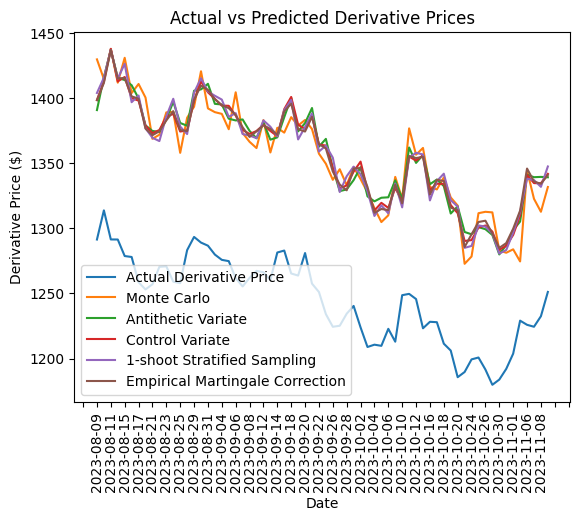

In [22]:
import matplotlib.dates as mdates

actual_derivative_range_df = actual_derivative_df[actual_derivative_df['date'].isin(actual_dates)]
predicted_derivative_df = pd.DataFrame(predicted_derivative_dict)

plt.plot(actual_derivative_range_df['date'], actual_derivative_range_df['value'], label='Actual Derivative Price')
plt.plot(predicted_derivative_df['date'], predicted_derivative_df['MC_Mean'], label='Monte Carlo')
plt.plot(predicted_derivative_df['date'], predicted_derivative_df['AV_Mean'], label='Antithetic Variate')
plt.plot(predicted_derivative_df['date'], predicted_derivative_df['CV_Mean'], label='Control Variate')
plt.plot(predicted_derivative_df['date'], predicted_derivative_df['SS_Mean'], label='1-shoot Stratified Sampling')
plt.plot(predicted_derivative_df['date'], predicted_derivative_df['EMS_Mean'], label='Empirical Martingale Correction')
plt.legend()
plt.title("Actual vs Predicted Derivative Prices")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Derivative Price ($)")
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
# plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()

In [23]:
# Calculate difference for each method used
print(f"Average Difference from Actual Price for {Nsim} simulations:")
print(f"- Monte Carlo: {(predicted_derivative_df['MC_Mean'].values - actual_derivative_range_df['value'].values).mean()}")
print(f"- Antithetic Variates: {(predicted_derivative_df['AV_Mean'].values - actual_derivative_range_df['value'].values).mean()}")
print(f"- Control Variates: {(predicted_derivative_df['CV_Mean'].values - actual_derivative_range_df['value'].values).mean()}")
print(f"- 1-shoot Stratified Sampling: {(predicted_derivative_df['SS_Mean'].values - actual_derivative_range_df['value'].values).mean()}")
print(f"- Empirical Martingale Correction: {(predicted_derivative_df['EMS_Mean'].values - actual_derivative_range_df['value'].values).mean()}")

Average Difference from Actual Price for 1000 simulations:
- Monte Carlo: 110.38010267887721
- Antithetic Variates: 112.39792106455867
- Control Variates: 111.75833631670001
- 1-shoot Stratified Sampling: 111.9119524911813
- Empirical Martingale Correction: 111.73144907796218


This shows that our GBM model overestimates the actual derivative price by more than EUR100, which indicates that our model differs greatly from the model that Credit Suisse uses to price their own option.